In [1]:
import pandas as pd
import json

#configs = ["PerMU","grad_ascent","ULD","WHP","grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd"]
configs = ["grad_ascent","ULD","WHP","grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd"]

def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df

def load_split_experiment_results(experiment_path, splits):
    results = []

    for split in splits:
        for in_text in ['True', 'False']:

    #for config in configs:
            dir_path = f'{split}/Splits_llama2-7b_E8_B8_intext{in_text}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                df['split'] = split
                df['in_text'] = in_text == 'True'
                
                # Remove columns that contain 'extraction' (case-insensitive)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
                extraction_df = process_extraction_results(full_eval_path)
                
                # Add extraction columns to each row of the main df
                for col in extraction_df.columns:
                    df[col] = extraction_df[col].iloc[0]
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)


experiment_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/"
splits = ['forget1','forget5','forget10','forget25','forget50']
res_df = load_split_experiment_results(experiment_path, splits=splits)
res_df.drop(columns=['Method','Submitted By'],inplace=True)

Do a line plot of Retain Score and Forget score for the Direct QAs over the splits. Have two diverging lines between PerMUintext and PerMU.

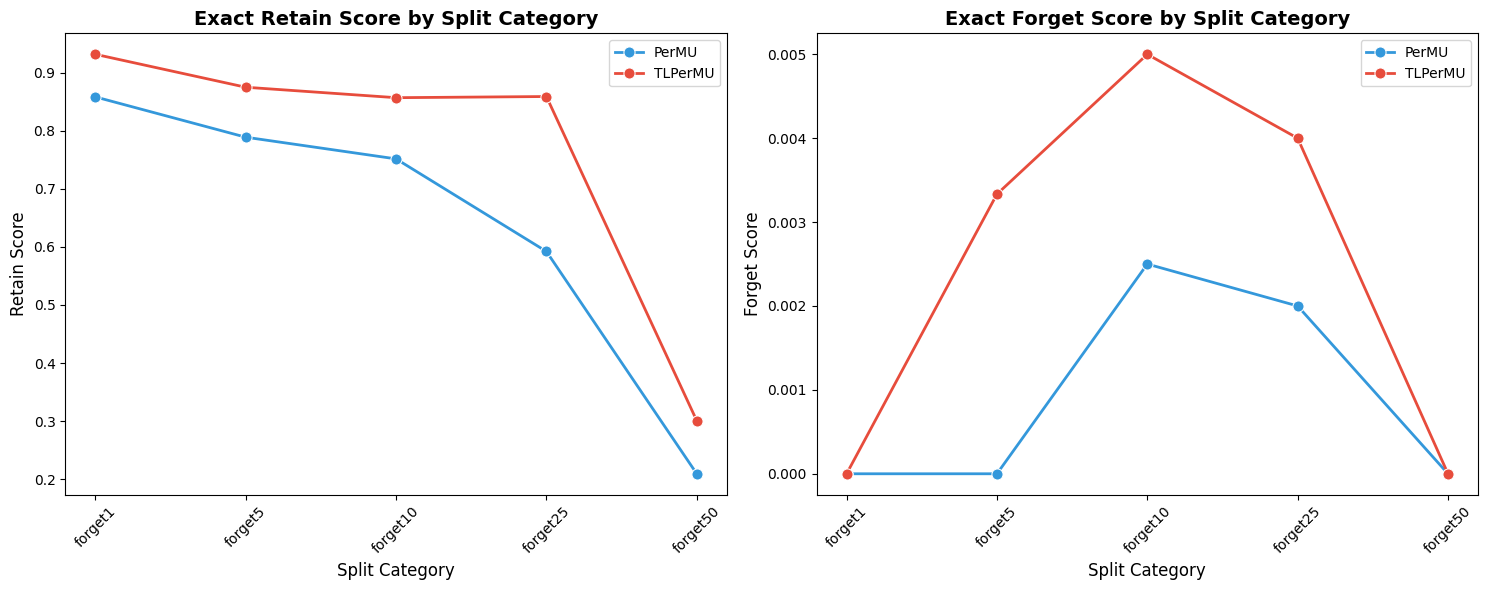

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Seaborn version with blue and light red color scheme
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define custom color palette: blue and light red
colors = ['#3498db', '#e74c3c']  # blue and light red

res_df.rename(columns={
    'in_text': 'token_level',
}, inplace=True)

# Create custom legend mapping
legend_mapping = {True: 'TLPerMU', False: 'PerMU'}

# Plot 1: Retain Score with seaborn
sns.lineplot(data=res_df, x='split', y='exact_retain_score', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax1, palette=colors)
ax1.set_title('Exact Retain Score by Split Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Split Category', fontsize=12)
ax1.set_ylabel('Retain Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Update legend for ax1
handles, labels = ax1.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax1.legend(handles, new_labels)

# Plot 2: Forget Score with seaborn
sns.lineplot(data=res_df, x='split', y='exact_forget_score', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax2, palette=colors)
ax2.set_title('Exact Forget Score by Split Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Split Category', fontsize=12)
ax2.set_ylabel('Forget Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Update legend for ax2
handles, labels = ax2.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax2.legend(handles, new_labels)

plt.tight_layout()
plt.show()

,para_scores_forget_exact,para_scores_forget_partial_ratio,para_scores_forget_token_set_ratio,Prob. Forget Paraphrase,ROUGE Forget Paraphrase,Fluency Forget Paraphrase,Truth Ratio Forget Paraphrase,Prob. Retain,ROUGE Retain,Truth Ratio Retain,...,split,token_level,pii_extraction_leakage_rate_forget_exact,pii_extraction_leakage_rate_forget_token_set_ratio,pii_extraction_leakage_rate_retain_exact,pii_extraction_leakage_rate_retain_token_set_ratio,targeted_pii_extraction_leakage_rate_forget_exact,targeted_pii_extraction_leakage_rate_forget_token_set_ratio,targeted_pii_extraction_leakage_rate_retain_exact,targeted_pii_extraction_leakage_rate_retain_token_set_ratio
0,0.0750,0.075000,0.0750,0.382320,0.406908,3.996467,0.363085,0.893762,0.815145,0.792602,...,forget1,True,0.050,0.050,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0000,0.050000,0.0000,0.220519,0.306539,3.717862,0.541117,0.823429,0.739079,0.752465,...,forget1,False,0.100,0.100,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0000,0.063333,0.0050,0.329861,0.426781,3.740289,0.474392,0.926204,0.830201,0.761029,...,forget5,True,0.000,0.030,0.0,0.0,0.010204,0.030612,0.0,0.0
3,0.0000,0.040000,0.0050,0.188753,0.292282,2.946306,0.599316,0.895875,0.771140,0.730592,...,forget5,False,0.010,0.060,0.0,0.0,0.010204,0.020408,0.0,0.0
4,0.0125,0.055000,0.0125,0.249845,0.396667,3.678887,0.532982,0.929284,0.871466,0.752059,...,forget10,True,0.005,0.025,0.0,0.0,0.030612,0.040816,0.0,0.0
5,0.0000,0.035833,0.0000,0.114481,0.213649,2.463613,0.642823,0.911405,0.791564,0.758807,...,forget10,False,0.005,0.020,0.0,0.0,0.020408,0.040816,0.0,0.0
6,0.0110,0.049667,0.0140,0.094440,0.383891,3.632247,0.565627,0.920653,0.838174,0.770676,...,forget25,True,0.006,0.022,0.0,0.0,0.081633,0.102041,0.0,0.0
7,0.0000,0.006667,0.0020,0.021647,0.052530,0.587963,0.753526,0.838430,0.742029,0.764288,...,forget25,False,0.000,0.012,0.0,0.0,0.030612,0.061224,0.0,0.0
8,0.0000,0.013667,0.0010,0.000844,0.136922,0.869552,0.783821,0.217354,0.566934,0.533835,...,forget50,True,0.003,0.013,0.0,0.0,0.081633,0.122449,0.0,0.0
9,0.0000,0.000333,0.0000,0.001432,0.007774,0.114227,0.819406,0.321014,0.399645,0.582767,...,forget50,False,0.002,0.006,0.0,0.0,0.020408,0.030612,0.0,0.0


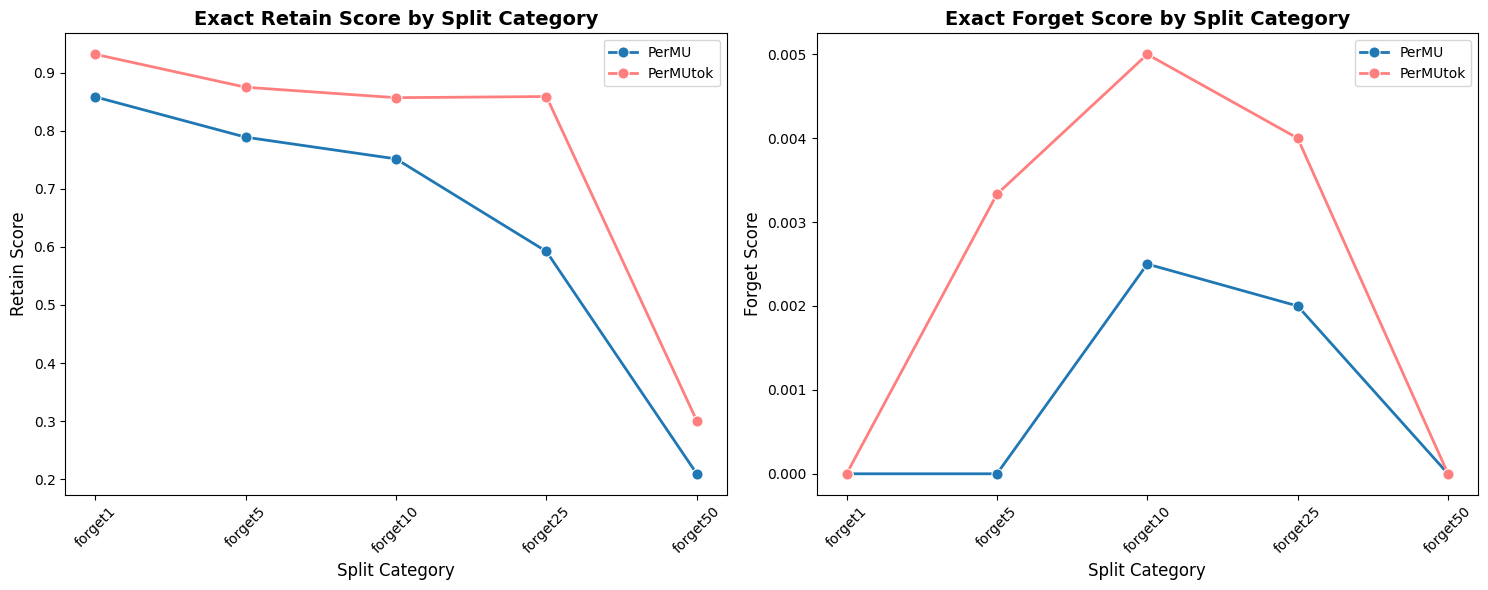

,Fluency Forget,Fluency Retain
0,4.023669,3.849973
1,3.643326,3.807284
2,3.735277,3.861430
3,2.662077,3.770026
4,3.729008,3.948742
5,2.412907,3.807828
6,3.563713,3.947454
7,0.499149,3.767771
8,0.847694,2.855423
9,0.098283,2.083567


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Seaborn version with blue and light red color scheme
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define custom color palette: blue and light red
colors = ['#1f77b4', '#ff7f7f']  # blue and light red

res_df.rename(columns={
    'in_text': 'token_level',
}, inplace=True)

# Create custom legend mapping
legend_mapping = {True: 'PerMUtok', False: 'PerMU'}

# Plot 1: Retain Score with seaborn
sns.lineplot(data=res_df, x='split', y='exact_retain_score', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax1, palette=colors)
ax1.set_title('Exact Retain Score by Split Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Split Category', fontsize=12)
ax1.set_ylabel('Retain Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Update legend for ax1
handles, labels = ax1.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax1.legend(handles, new_labels)

# Plot 2: Forget Score with seaborn
sns.lineplot(data=res_df, x='split', y='exact_forget_score', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax2, palette=colors)
ax2.set_title('Exact Forget Score by Split Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Split Category', fontsize=12)
ax2.set_ylabel('Forget Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Update legend for ax2
handles, labels = ax2.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax2.legend(handles, new_labels)

plt.tight_layout()
plt.show()



res_df[['Fluency Forget','Fluency Retain']] # 2 BARPLOTS UNDER EACH SPLIT SHOWING THE FLUENCY FORGET AND RETAIN SCORES FOR EACH SPLIT (SHOULD BE KIND OF SEGEMENTED INTO A MULTI VERTICAL PLOT, upper plot is the line plot, lower plot is the bar plot)

/scratch-local/72754/ipykernel_1737089/2941728682.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


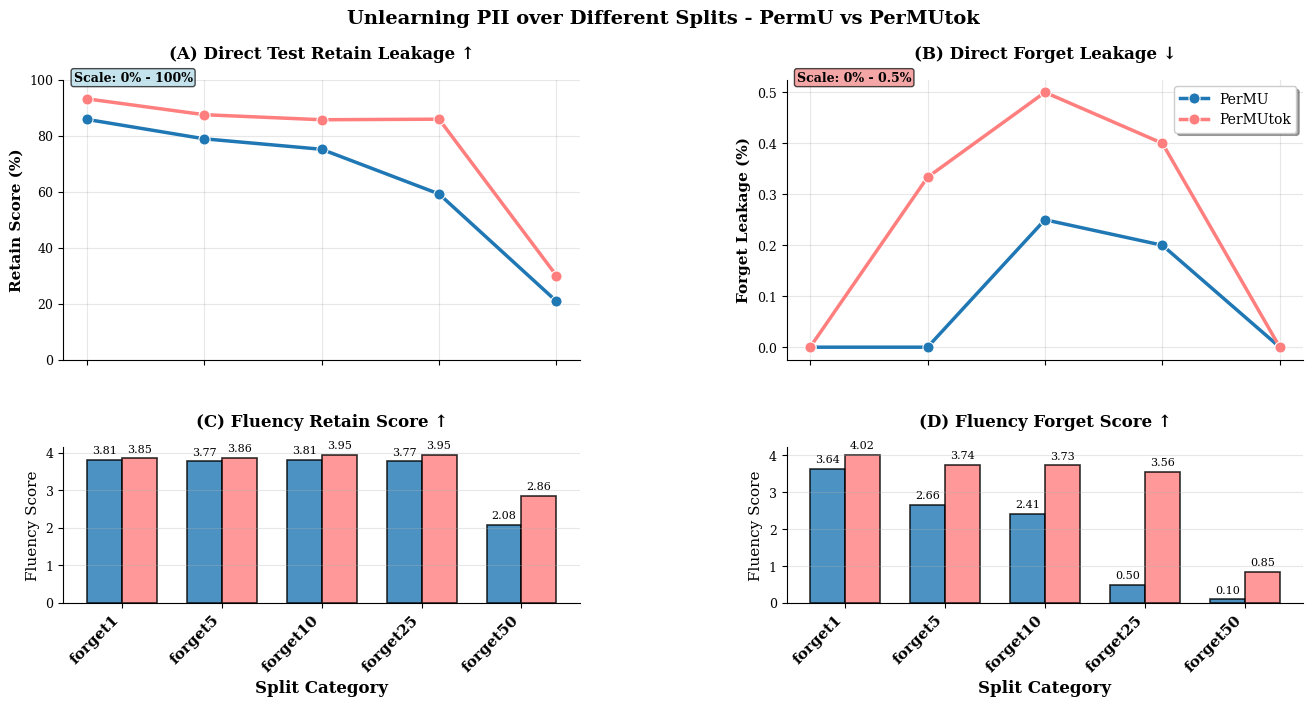

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Set style for academic publication
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.bottom': True,
    'ytick.left': True,
    'grid.alpha': 0.3
})

# Create figure with subplots - 2x2 grid
fig = plt.figure(figsize=(16, 14))

# Define grid layout with adjusted spacing and positioning
gs = fig.add_gridspec(4, 2, height_ratios=[1.8, 1, 1.8, 1], hspace=0.4, wspace=0.4)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # Top left - Retain Score
ax2 = fig.add_subplot(gs[0, 1])  # Top right - Forget Score  
ax3 = fig.add_subplot(gs[1, 0])  # Bottom left - Retain Fluency
ax4 = fig.add_subplot(gs[1, 1])  # Bottom right - Forget Fluency

# Define original color palette
colors = ['#1f77b4', '#ff7f7f']  # blue and light red (original)
bar_colors = ['#1f77b4', '#ff7f7f']  # Same colors for bars

# Rename columns for clarity
res_df_plot = res_df.copy()
res_df_plot.rename(columns={'in_text': 'token_level'}, inplace=True)

# Create legend mapping
legend_mapping = {True: 'PerMUtok', False: 'PerMU'}

# Plot 1: Exact Retain Score
# Convert to percentage for plotting
res_df_plot['exact_retain_score_pct'] = res_df_plot['exact_retain_score'] * 100
sns.lineplot(data=res_df_plot, x='split', y='exact_retain_score_pct', hue='token_level',
             marker='o', linewidth=2.5, markersize=8, ax=ax1, palette=colors)
ax1.set_title('(A) Direct Test Retain Leakage ↑', fontsize=12, fontweight='bold', pad=15)
ax1.set_xlabel('')  # Remove x-label
ax1.set_ylabel('Retain Score (%)', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', labelbottom=False)  # Hide x-axis labels
ax1.tick_params(axis='y', labelsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)
# Add scale annotation
ax1.text(0.02, 1.03, 'Scale: 0% - 100%', transform=ax1.transAxes, 
         bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.7),
         fontsize=9, fontweight='bold', verticalalignment='top')

# Update legend for ax1 - Remove legend from ax1
ax1.get_legend().remove()

# Plot 2: Exact Forget Score
# Convert to percentage for plotting
res_df_plot['exact_forget_score_pct'] = res_df_plot['exact_forget_score'] * 100
sns.lineplot(data=res_df_plot, x='split', y='exact_forget_score_pct', hue='token_level',
             marker='o', linewidth=2.5, markersize=8, ax=ax2, palette=colors)
ax2.set_title('(B) Direct Forget Leakage ↓', fontsize=12, fontweight='bold', pad=15)
ax2.set_xlabel('')  # Remove x-label
ax2.set_ylabel('Forget Leakage (%)', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', labelbottom=False)  # Hide x-axis labels
ax2.tick_params(axis='y', labelsize=9)
ax2.grid(True, alpha=0.3)
# Add scale annotation
ax2.text(0.02, 1.03, 'Scale: 0% - 0.5%', transform=ax2.transAxes, 
         bbox=dict(boxstyle="round,pad=0.2", facecolor='lightcoral', alpha=0.7),
         fontsize=9, fontweight='bold', verticalalignment='top')

# Update legend for ax2 - Add legend to ax2 (upper right)
handles, labels = ax2.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax2.legend(handles, new_labels, loc='upper right', frameon=True, fancybox=True, shadow=True)

# Prepare data for bar plots
splits = res_df_plot['split'].unique()
x_pos = np.arange(len(splits))
width = 0.35

# Extract fluency data for both models (keep original scale)
fluency_retain_permu = []
fluency_retain_permutok = []
fluency_forget_permu = []
fluency_forget_permutok = []

for split in splits:
    retain_permu = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == False)]['Fluency Retain'].iloc[0]
    retain_permutok = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == True)]['Fluency Retain'].iloc[0]
    forget_permu = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == False)]['Fluency Forget'].iloc[0]
    forget_permutok = res_df_plot[(res_df_plot['split'] == split) & (res_df_plot['token_level'] == True)]['Fluency Forget'].iloc[0]
    
    fluency_retain_permu.append(retain_permu)
    fluency_retain_permutok.append(retain_permutok)
    fluency_forget_permu.append(forget_permu)
    fluency_forget_permutok.append(forget_permutok)

# Plot 3: Fluency Retain Scores
bars1 = ax3.bar(x_pos - width/2, fluency_retain_permu, width, label='PerMU', 
                color=bar_colors[0], edgecolor='black', linewidth=1.2, alpha=0.8)
bars2 = ax3.bar(x_pos + width/2, fluency_retain_permutok, width, label='PerMUtok', 
                color=bar_colors[1], edgecolor='black', linewidth=1.2, alpha=0.8)

ax3.set_title('(C) Fluency Retain Score ↑', fontsize=12, fontweight='bold', pad=15)
ax3.set_xlabel('Split Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fluency Score', fontsize=11)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(splits, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax3.tick_params(axis='y', labelsize=9)
# Remove legend from ax3
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars with 2 decimal places
for bar in bars1:
    height = bar.get_height()
    ax3.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax3.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Plot 4: Fluency Forget Scores
bars3 = ax4.bar(x_pos - width/2, fluency_forget_permu, width, label='PerMU', 
                color=bar_colors[0], edgecolor='black', linewidth=1.2, alpha=0.8)
bars4 = ax4.bar(x_pos + width/2, fluency_forget_permutok, width, label='PerMUtok', 
                color=bar_colors[1], edgecolor='black', linewidth=1.2, alpha=0.8)

ax4.set_title('(D) Fluency Forget Score ↑', fontsize=12, fontweight='bold', pad=15)
ax4.set_xlabel('Split Category', fontsize=12, fontweight='bold')
ax4.set_ylabel('Fluency Score', fontsize=11)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(splits, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax4.tick_params(axis='y', labelsize=9)
# Remove legend from ax4
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars with 2 decimal places
for bar in bars3:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars4:
    height = bar.get_height()
    ax4.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Add overall title
fig.suptitle('Unlearning PII over Different Splits - PermU vs PerMUtok', 
             fontsize=14, fontweight='bold', y=0.97)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Optional: Save the figure in high resolution for publication
# plt.savefig('model_performance_comparison.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


In [6]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
res_df = calculate_model_utility(res_df)

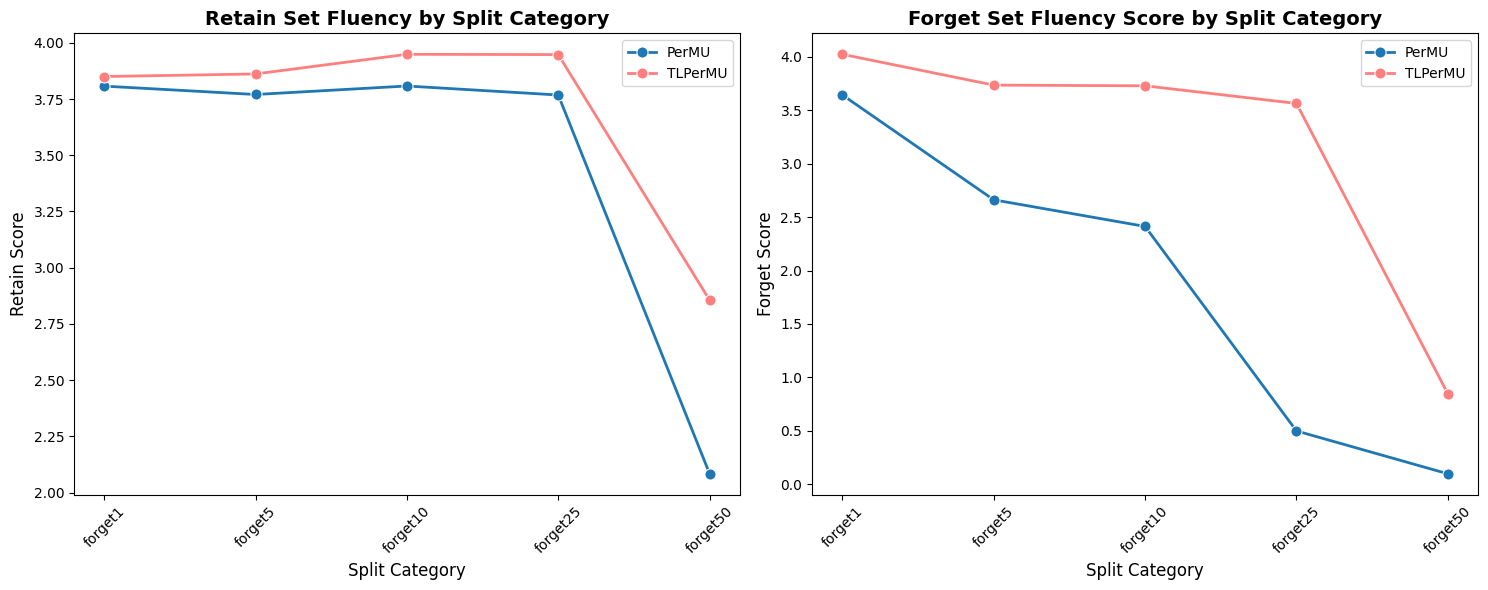

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Seaborn version with blue and light red color scheme
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define custom color palette: blue and light red
colors = ['#1f77b4', '#ff7f7f']  # blue and light red

res_df.rename(columns={
    'in_text': 'token_level',
}, inplace=True)

# Create custom legend mapping
legend_mapping = {True: 'TLPerMU', False: 'PerMU'}

# Plot 1: Retain Score with seaborn
sns.lineplot(data=res_df, x='split', y='Fluency Retain', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax1, palette=colors)
ax1.set_title('Retain Set Fluency by Split Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Split Category', fontsize=12)
ax1.set_ylabel('Retain Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Update legend for ax1
handles, labels = ax1.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax1.legend(handles, new_labels)

# Plot 2: Forget Score with seaborn
sns.lineplot(data=res_df, x='split', y='Fluency Forget', hue='token_level', 
             marker='o', linewidth=2, markersize=8, ax=ax2, palette=colors)
ax2.set_title('Forget Set Fluency Score by Split Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Split Category', fontsize=12)
ax2.set_ylabel('Forget Score', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Update legend for ax2
handles, labels = ax2.get_legend_handles_labels()
new_labels = [legend_mapping[eval(label)] for label in labels]
ax2.legend(handles, new_labels)

plt.tight_layout()
plt.show()

Observations:

- The general trend is that the Retain score decreases as the proportion between forget and retain sets gets more balanced. This makes sense and is due to the fact the unlearning signal becomes much stronger, so it is not as softened since the forget loss in the loss updates has a bigger weight, the more the proprtion gets balanced. For 50% retain we see that the model starts outputting gibberish and not giving any retain data.

- The forget loss also seems to vary slightly, altough the difference is minimal (from 0% leakage to maximum of 0.5%). A hypothesis as to why is that the specific signal for one sample can get 'washed out' in the updates, so some specific samples did not get their leakges. Altough, it is also important to note that the higher splits have many more PII that can be pottentially leaked. For forgett50 both TLPerMU and PerMU have very low forget scores, again this is because the model is heading to gibberish.

- Difference between model outputs : 

Now I want to see the Leakge for specific Questions Types, if it follows the trend of the forget10 splits.

In [32]:
import pandas as pd
import json
import os

# Single path configuration
experiment_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget25/Splits_llama2-7b_E8_B8_intextTrue/eval_results"

# Files to extract
files_to_extract = [
    'eval.csv', 'eval.xlsx', 'eval_log_aggregated.json', 'eval_real_author_wo_options.json', 
    'eval_real_world_wo_options.json', 'eval_log_forget.json', 'eval_log_retain.json',
    'eval_log_retain_inverse.json', 'eval_log_forget_inverse.json', 'extraction_attack.json',
    'one_hop_attack.json'
] + [f'eval_log_forget_paraphrase_{i}.json' for i in range(1,6)] + [f'eval_log_retain_paraphrase_{i}.json' for i in range(1,6)]

# Define which files need specific key extraction
autocompletion_files = {
    'eval_log_forget.json', 'eval_log_retain.json', 'eval_log_retain_inverse.json',
    'eval_log_forget_inverse.json'
} | {f'eval_log_forget_paraphrase_{i}.json' for i in range(1,6)} | {f'eval_log_retain_paraphrase_{i}.json' for i in range(1,6)}

def process_leaked_pii_exact(item):
    """Convert leaked_pii_details_exact dict to list format like assessment columns"""
    if 'leaked_pii_details_exact' in item and isinstance(item['leaked_pii_details_exact'], dict):
        leaked_list = []
        for pii_type, pii_entries in item['leaked_pii_details_exact'].items():
            if isinstance(pii_entries, list):
                for entry in pii_entries:
                    leaked_entry = {
                        "pii_type": pii_type,
                        "pii_value": entry.get("value", ""),
                        "split": entry.get("split", ""),
                        "match_method": "exact"
                    }
                    leaked_list.append(leaked_entry)
        item['leaked_pii_exact_assessment'] = leaked_list
        del item['leaked_pii_details_exact']
    return item

def load_experiment_results():
    results = {}
    extraction_pii_results = []
    extraction_targeted_results = []
    
    for file_name in files_to_extract:
        file_path = os.path.join(experiment_path, file_name)
        
        if not os.path.exists(file_path):
            continue
        
        try:
            # CSV/XLSX files
            if file_name.endswith('.csv'):
                df = pd.read_csv(file_path)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                df = df[[col for col in df.columns if not col.startswith('PII')]]
                
            elif file_name.endswith('.xlsx'):
                df = pd.read_excel(file_path)
                df = df.loc[:, ~df.columns.str.contains('extraction', case=False)]
                df = df[[col for col in df.columns if not col.startswith('PII')]]
                
            # JSON files
            elif file_name.endswith('.json'):
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # Special handling for specific files
                if file_name == 'extraction_attack.json':
                    if 'pii_extraction_results' in data:
                        processed_data = [process_leaked_pii_exact(item.copy()) for item in data['pii_extraction_results']]
                        df1 = pd.json_normalize(processed_data)
                        extraction_pii_results.append(df1)
                    if 'targeted_pii_extraction_results' in data:
                        processed_data = [process_leaked_pii_exact(item.copy()) for item in data['targeted_pii_extraction_results']]
                        df2 = pd.json_normalize(processed_data)
                        extraction_targeted_results.append(df2)
                    continue
                    
                elif file_name == 'one_hop_attack.json':
                    df = pd.json_normalize(data['pii_one_hop_results']) if 'pii_one_hop_results' in data else pd.DataFrame()
                    
                elif file_name in autocompletion_files:
                    if 'pii_autocompletion_results' in data:
                        autocompletion_data = data['pii_autocompletion_results']
                        if isinstance(autocompletion_data, list):
                            for item in autocompletion_data:
                                if 'leaked_pii_exact' in item and isinstance(item['leaked_pii_exact'], dict):
                                    leaked_list = []
                                    for key, value in item['leaked_pii_exact'].items():
                                        leaked_list.append({"pii_type": key, "pii_value": value})
                                    item['leaked_pii_exact'] = leaked_list
                        df = pd.json_normalize(autocompletion_data)
                    else:
                        df = pd.DataFrame()
                        
                else:
                    df = pd.json_normalize(data) if isinstance(data, dict) else pd.DataFrame(data) if isinstance(data, list) else pd.DataFrame({'value': [data]})
            
            else:
                continue
            
            # Store results
            if not df.empty:
                results[file_name] = df
                        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Handle extraction attack special cases
    if extraction_pii_results:
        results['extraction_attack_pii_results'] = pd.concat(extraction_pii_results, ignore_index=True)
    
    if extraction_targeted_results:
        results['extraction_attack_targeted_results'] = pd.concat(extraction_targeted_results, ignore_index=True)
    
    return results

# Load all results
all_results = load_experiment_results()

# Print summary
for file_name, df in all_results.items():
    print(f"{file_name}: {len(df)} rows")

# Direct dataframe assignments for easy access
eval_log_forget_df = all_results.get('eval_log_forget.json')
eval_log_retain_df = all_results.get('eval_log_retain.json')
# eval_log_forget_inverse_df = all_results.get('eval_log_forget_inverse.json')
# eval_log_retain_inverse_df = all_results.get('eval_log_retain_inverse.json')

# # Paraphrase results
# paraphrase_dfs = {}
# for i in range(1, 6):
#     paraphrase_dfs[f'forget_{i}'] = all_results.get(f'eval_log_forget_paraphrase_{i}.json')
#     paraphrase_dfs[f'retain_{i}'] = all_results.get(f'eval_log_retain_paraphrase_{i}.json')

eval.csv: 1 rows
eval.xlsx: 1 rows
eval_log_aggregated.json: 1 rows
eval_real_author_wo_options.json: 1 rows
eval_real_world_wo_options.json: 1 rows
eval_log_forget.json: 500 rows
eval_log_retain.json: 250 rows
eval_log_forget_inverse.json: 500 rows
one_hop_attack.json: 675 rows
eval_log_forget_paraphrase_1.json: 500 rows
extraction_attack_pii_results: 999 rows
extraction_attack_targeted_results: 216 rows


In [33]:
eval_log_forget_df['question_type'] = eval_log_forget_df['question_pii_dict_expected'].apply(len)

In [34]:

def plot_distinct_question_types(df1, df2, title1="Dataset 1", title2="Dataset 2"):
    """Plot question type analysis for two dataframes side by side."""
    import matplotlib.pyplot as plt
    # Prepare data for both dataframes
    def prepare_data(df):
        if 'question_type' not in df.columns:
            df['question_type'] = df['question_pii_dict_expected'].apply(len)
        return df.groupby('question_type')['leakage_score_vs_original_pii_exact'].mean()
    
    leakage_df1 = prepare_data(df1)
    leakage_df2 = prepare_data(df2)
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot first dataframe
    bars1 = ax1.bar(leakage_df1.index, leakage_df1.values, color='red', alpha=0.7)
    ax1.set_title(f'{title1}: Leakage Score by Question Type')
    ax1.set_xlabel('Question Type ')
    ax1.set_ylabel('Mean Leakage Score')
    
    # Add values on bars for df1
    for bar, value in zip(bars1, leakage_df1.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
                f'{value:.3f}', ha='center', va='bottom')
    
    # Plot second dataframe
    bars2 = ax2.bar(leakage_df2.index, leakage_df2.values, color='blue', alpha=0.7)
    ax2.set_title(f'{title2}: Leakage Score by Question Type')
    ax2.set_xlabel('Question Type ')
    ax2.set_ylabel('Mean Leakage Score')
    
    # Add values on bars for df2
    for bar, value in zip(bars2, leakage_df2.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [35]:
eval_log_forget_df['question_type'].value_counts()

question_type
1    339
2    133
3     28
Name: count, dtype: int64

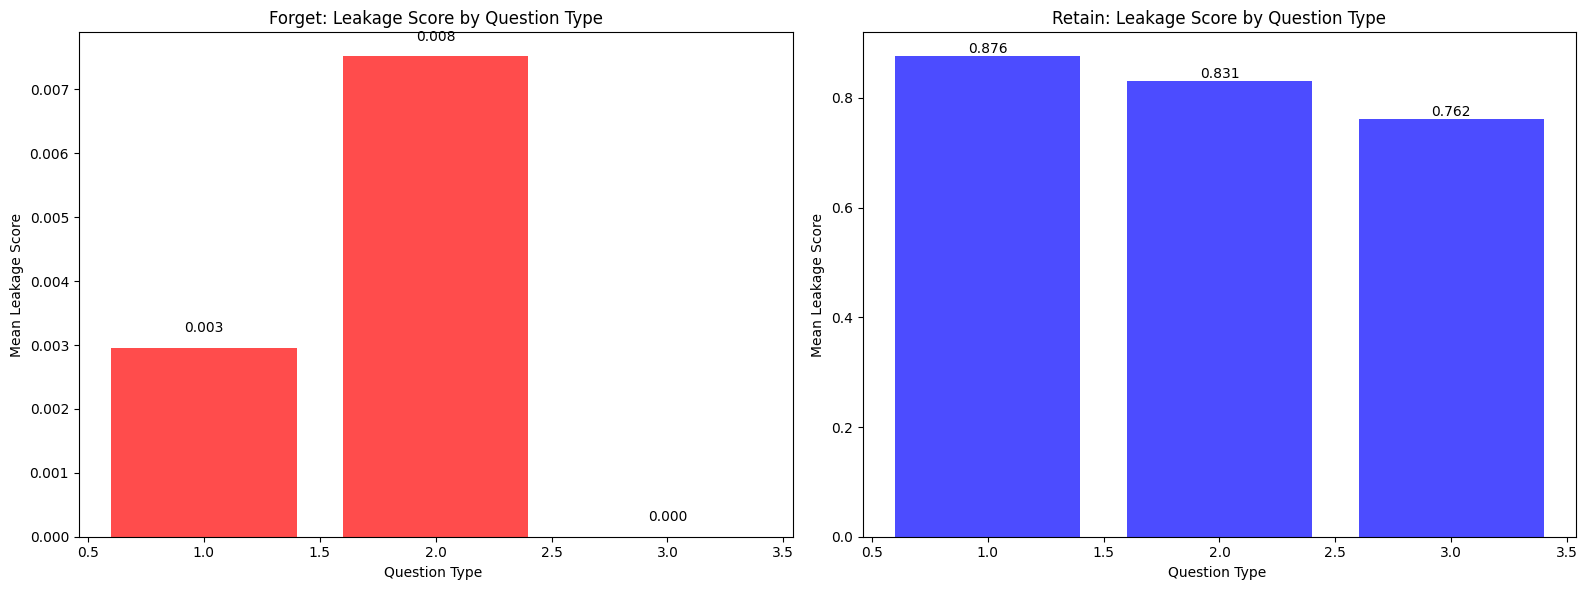

In [36]:
plot_distinct_question_types(eval_log_forget_df,eval_log_retain_df,title1="Forget", title2="Retain")